In [4]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


from datasets import load_dataset

dataset = load_dataset("cifar10")

c:\Users\Erick\anaconda3\envs\Study\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 131930.79 examples/s]


# Organizando os Dadoas

In [5]:
X_train_png  = dataset['train']['img']
y_train      = dataset['train']['label']

X_test_png  = dataset['test']['img']
y_test      = dataset['test']['label']



In [6]:
""" X_train = []
X_test  = []
transf = transforms.ToTensor()


for x in X_train_png:
    prov = transf(x)
    X_train.append(prov)
    


    
for x in X_test_png:
    prov = transf(x)
    X_test.append(prov) """




' X_train = []\nX_test  = []\ntransf = transforms.ToTensor()\n\n\nfor x in X_train_png:\n    prov = transf(x)\n    X_train.append(prov)\n    \n\n\n    \nfor x in X_test_png:\n    prov = transf(x)\n    X_test.append(prov) '

# Dataset, DataLoader

In [7]:

class CIFAR10(Dataset):
    
    def __init__(self,X,y, transform=transforms.ToTensor()):
        
        self.transform = transform
        self.X = X
        self.y = y
          
    def __getitem__(self,idx):
        
        img_tensor = self.transform(self.X[idx])
        return img_tensor,self.y[idx]
    
    def __len__(self):
        return len(self.y)
    
    
    
# 

In [8]:
train_dl = DataLoader(CIFAR10(X_train_png,y_train),  batch_size = len(X_train_png) )
test_dl  = DataLoader(CIFAR10(X_test_png, y_test),  batch_size = len(X_test_png) )
                          

# Criando o Modelo

In [9]:
class MLP_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.F1 = nn.Flatten()
        self.L1  = nn.Linear(3*32*32,64)
        self.L2  = nn.Linear(64, 32)
        self.L3  = nn.Linear(32,10)
        self.A   = nn.ReLU()
        
        
    def forward(self,x):
        
        x = self.F1(x)
        x = self.L1(x) 
        x = self.A(x)
        x = self.L2(x) 
        x = self.A(x)
        x = self.L3(x)
        x = self.A(x)
        
        return x
        

In [18]:

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [22]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
	
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")


Is CUDA supported by this system? True
CUDA version: 12.4
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce GTX 1650


# Training

In [10]:

def training( N_Epochs, model, loss_fn, opt  ):
    
    loss_list = []
    
    for epoch in tqdm(range(N_Epochs+1)):
        for xb, yb in train_dl:
            
            
            
            y_pred = model(xb.float())
            loss   = loss_fn(y_pred, yb.long())
        
            
            opt.zero_grad()
            loss.backward()
            opt.step()
        
            loss_list.append(loss.item())
    
    L1_weights = MLP_Model().L1.weight.detach()
    L2_weights = MLP_Model().L2.weight.detach()
    L3_weights = MLP_Model().L3.weight.detach()
    
    
       
    
    plt.figure(figsize = (14,6))
    plt.title("cost decay")
    plt.plot(loss_list)
    plt.xlabel("epoch")
    plt.ylabel("cost")
    
    return L1_weights, L2_weights, L3_weights

100%|██████████| 151/151 [13:15<00:00,  5.27s/it]


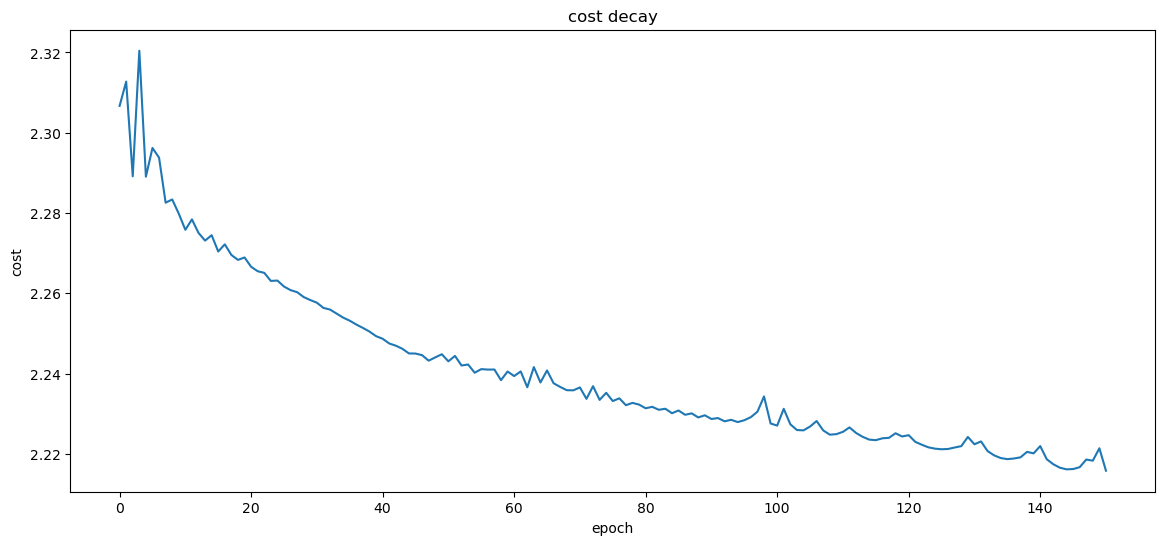

In [12]:
model = MLP_Model()

epochs = 150

opt        = torch.optim.Adam( model.parameters(), lr=0.003 )

loss_fn    = nn.CrossEntropyLoss( )   

x1,x2,x3 = training( epochs, model , loss_fn, opt )

# Evaluation

In [147]:
from sklearn.metrics import classification_report
with torch.no_grad():
    
    model.eval()
    
    y_pred = []
    y_true = []

    for xb, yb in test_dl:
        y_predb = model(xb.float())
        y_pred.append(y_predb)
        y_true.append(yb)
        
    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
  
    yf     = torch.argmax(y_pred, dim=1)

    print(classification_report(y_true, yf))        
    

              precision    recall  f1-score   support

           0       0.53      0.60      0.56      1000
           1       0.54      0.66      0.59      1000
           2       0.38      0.33      0.35      1000
           3       0.32      0.27      0.29      1000
           4       0.39      0.47      0.43      1000
           5       0.42      0.35      0.38      1000
           6       0.54      0.47      0.50      1000
           7       0.51      0.54      0.53      1000
           8       0.63      0.63      0.63      1000
           9       0.53      0.52      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000

